# Import necessary packages

In [1]:
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow
import torchvision
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def reassign_point(old, new, point):
	a = int(round(((new*point)/old),0))
	return a

def reshape(img):

	desired_size = 400 
	
	img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
	#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	
	print(img.shape)
	rows, cols = img.shape


	old_size = img.shape[:2] # old_size is in (height, width) format

	ratio = float(desired_size)/max(old_size)
	new_size = tuple([int(x*ratio) for x in old_size])

	# new_size should be in (width, height) format
	img = cv2.resize(img, (new_size[1], new_size[0]))

	delta_w = desired_size - new_size[1]
	delta_h = desired_size - new_size[0]
	top, bottom = delta_h//2, delta_h-(delta_h//2)
	left, right = delta_w//2, delta_w-(delta_w//2)

	color = [0, 0, 0]
	new_im = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
	
	return new_im

# PCA Aligner

In [4]:
from sklearn.decomposition import PCA

def PCA_rotation(imgs):
	
    for index, img in enumerate(imgs):
		
    
        rows, cols = img.shape
        print(rows,cols)
        center = (cols/2,rows/2)


        img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

        img = img.astype(np.uint8)

        _, img = cv2.threshold(img, 210, 255, cv2.THRESH_BINARY);
        # print(np.unique(img))
        dots = np.argwhere(img >= 230 )
        if len(dots) == 0:
            continue

        pca = PCA(n_components=2)
        pca.fit_transform(dots)

        vec = pca.components_
        angle = np.degrees(np.arctan2(*vec.T[::-1])) % 360.0

        #move img to origin
        M = np.float32([[1,0,-(pca.mean_[1]-center[1])],[0,1,-(pca.mean_[0]-center[0])]])
        img = cv2.warpAffine(img,M,(cols,rows))

        #rotate img
        M = cv2.getRotationMatrix2D((center),-angle[1],1)
        img = cv2.warpAffine(img,M,(cols,rows))
                
        imgs[index] = img
	
    return imgs

# Blob Detection

In [61]:
import cv2
import numpy as np


def create_blob_detector(minDistBetweenBlobs=4, roi_size=(128, 128), blob_min_area=1, blob_min_int=.1, blob_max_int=.99, blob_th_step=1):
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = blob_min_area
    params.maxArea = roi_size[0]*roi_size[1]
    params.filterByCircularity = False
    params.filterByColor = False
    params.filterByConvexity = False
    params.filterByInertia = False
    params.minDistBetweenBlobs = minDistBetweenBlobs
    # blob detection only works with "uint8" images.
    params.minThreshold = int(blob_min_int*255)
    params.maxThreshold = int(blob_max_int*255)
    params.thresholdStep = blob_th_step
    return cv2.SimpleBlobDetector_create(params)

def take_points(images):
		
	thresh = 180

	maxValue = 255
	detector = create_blob_detector()
	dots_list = []
	kernel = np.ones((1,1),np.uint8)
	
	for img in images:
	
		img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
		_, img = cv2.threshold(img, thresh, maxValue, cv2.THRESH_BINARY);
		img = img.astype(np.uint8)
		keypoints = detector.detect(img)
		
		length, dots = takeDots(keypoints)
		
		if length != 19:
			img = cv2.dilate(img,kernel,iterations = 1)
			keypoints = detector.detect(img)
			length, dots = takeDots(keypoints)
		
		if length != 19:
			img = cv2.dilate(img,kernel,iterations = 3)
			keypoints = detector.detect(img)
			length, dots = takeDots(keypoints)
   
   
		if length != 19:
			img = cv2.erode(img,kernel,iterations = 2)
			keypoints = detector.detect(img)
			length, dots = takeDots(keypoints)
   

		# if length != 19:
		# 	print("err: ", length)
		# 	continue
            
		dots_list.append(dots)
	
	return dots_list
		
def takeDots(key):
	points = []
	for point in key:
		points.append((int(point.pt[0]),int(point.pt[1])))
	
	return len(points), points


# Wing Detection

In [21]:
import random as rng


def wing_detection(img, dilate=False, verbose_bbox=False, verbose_detected=False):


    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
    thresh = 255 - thresh;

    kernel = np.ones((5,5),np.uint8)

    if dilate:
        thresh = cv2.dilate(thresh, iterations= 2, kernel=kernel)

    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

    image_copy = img_gray.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)


    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)

    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])

    drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), dtype=np.uint8)

    biggest_bbox = None
    biggest_area = 0
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv2.drawContours(drawing, contours_poly, i, color)
        
        if boundRect[i][2]*boundRect[i][3] > biggest_area:
            area = boundRect[i][2]*boundRect[i][3]
            biggest_area = area
            biggest_bbox = boundRect[i]

            # cv2.rectangle(image_copy, (int(boundRect[i][0]), int(boundRect[i][1])), \
            #     (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
        # cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)

    cv2.rectangle(img, (int(biggest_bbox[0]), int(biggest_bbox[1])), \
                (int(biggest_bbox[0]+biggest_bbox[2]), int(biggest_bbox[1]+biggest_bbox[3])), color, 2)

    new_img = img[biggest_bbox[1]:biggest_bbox[1] + biggest_bbox[3], biggest_bbox[0]:biggest_bbox[0] + biggest_bbox[2]]

    if verbose_bbox:
        print("\nDetected Wing")
        cv2_imshow(img)
    if verbose_detected:
        print("\nCropped Image")
        cv2_imshow(new_img)

    return new_img





# Total Process

device is cuda


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Original image


Detected Wing


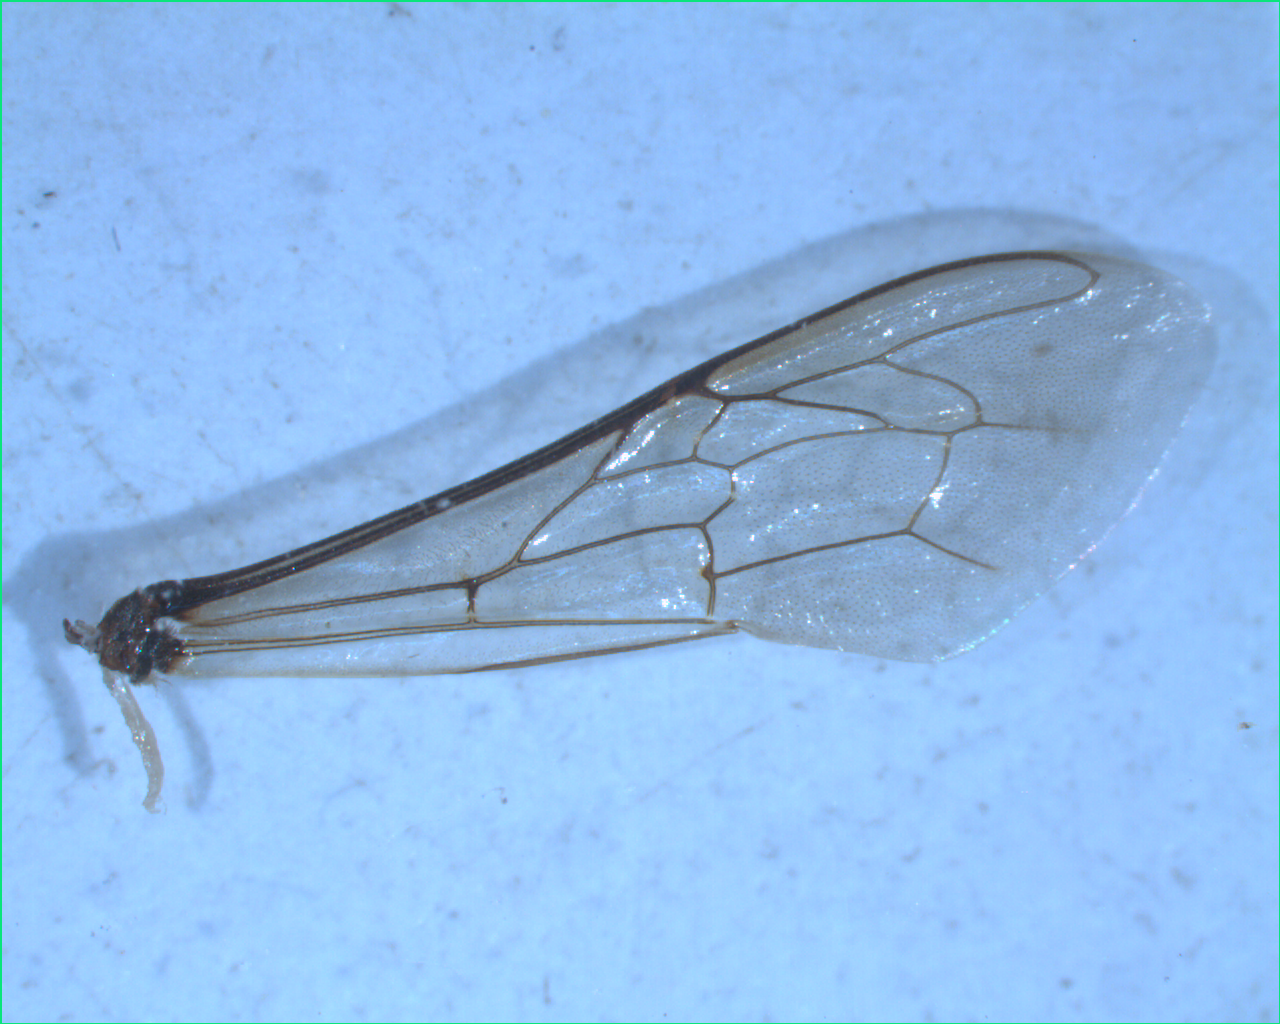

(1024, 1280)

Cropped Image



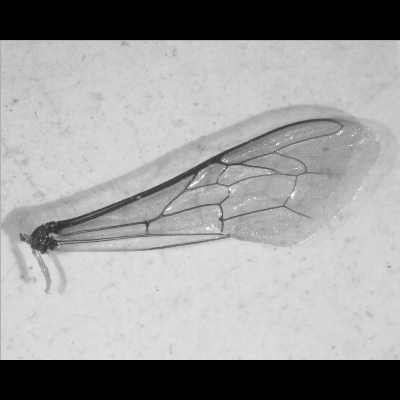

Predicted Mask



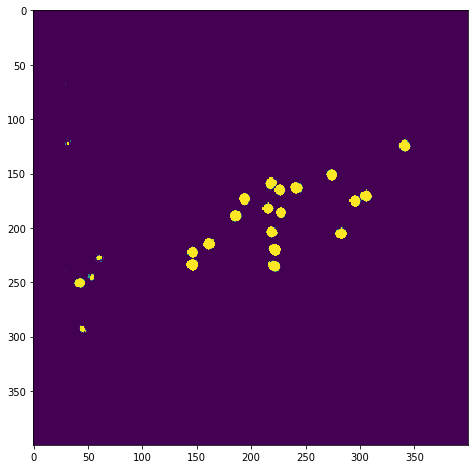



400 400
After PCA for image rotation



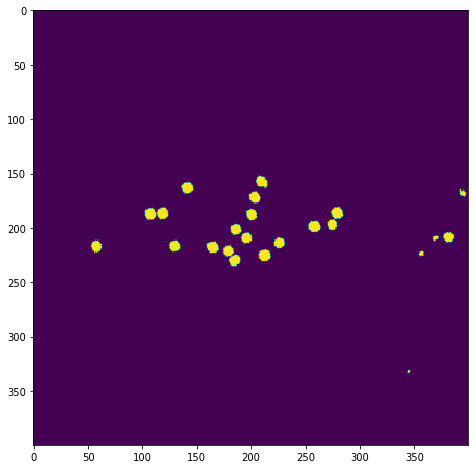


 Detected Points:

[[(345, 331), (184, 229), (356, 223), (212, 225), (179, 221), (164, 217), (129, 216), (57, 216), (226, 213), (369, 209), (195, 209), (381, 208), (185, 201), (258, 198), (274, 196), (200, 187), (118, 186), (107, 186), (279, 186), (203, 171), (394, 167), (141, 162), (209, 157)]]
number: 23

Detected Points on image:

(1024, 1280)


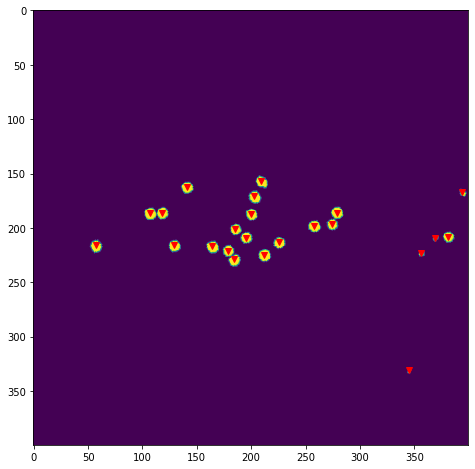


Detected Wing


In [ ]:


transforms = torchvision.transforms.Compose([
                                torchvision.transforms.ToPILImage(),
                                torchvision.transforms.Resize((400,400)),
                                torchvision.transforms.ToTensor(),
                                
                            ])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is {}".format(device))


model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False)

model2 = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False)

model.to(device)
model2.to(device)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/Bee/model-acc93.3741-e13.pt"))
model2.load_state_dict(torch.load("/content/gdrive/MyDrive/Bee/model-acc97.5291-e14.pt"))



IMAGE_PATH = "/content/cau13r.tif"

img = cv2.imread(IMAGE_PATH)



# img = cv2.medianBlur(img,5)

# Forward pass - compute outputs on input data using the model
print("Original image\n")
# cv2_imshow(img)


img = wing_detection(img, verbose_bbox=True)


img = reshape(img)
# clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(16,16))
# img = clahe.apply(img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("\nCropped Image\n")
cv2_imshow(img)

img = transforms(img)
img = img.to(device)
img = img.unsqueeze(0)
outputs = model(img)
outputs2 = model2(img)

def process(outputs):

    print("Predicted Mask\n")
    outputs = outputs.cpu().detach().numpy()
    outputs = outputs.squeeze(0)
    plt.imshow(outputs[0], interpolation='nearest')
    plt.show()
    print("\n")

    before_pca = outputs.copy()
    outputs = PCA_rotation(outputs)
    print("After PCA for image rotation\n")
    plt.imshow(outputs[0], interpolation='nearest')
    plt.show()


    outputs = outputs.astype(np.uint8)


    dot_list = take_points(outputs)

    dot_list_before_pca = take_points(before_pca)


    print("\n Detected Points:\n")
    print(dot_list)
    if len(dot_list) == 0:
        print("Error! Couldn't find 19 point!")
    else:
        print("number: {}\n".format(len(dot_list[0])))
        print("Detected Points on image:\n")

        img = cv2.imread(IMAGE_PATH)

        img = reshape(img)
        # img = cv2.cvtColor(img)
        for dot in dot_list[0]:

            plt.plot(dot[0], dot[1], marker='v', color="red")
            
            

            plt.imshow(outputs[0])
            # plt.imshow(img)
        plt.show()

        img = cv2.imread(IMAGE_PATH)
        img = wing_detection(img, verbose_bbox=True)
        img = reshape(img)
        print("number before pca: {}\n".format(len(dot_list_before_pca[0])))
        for dot in dot_list_before_pca[0]:
            print(dot)
            plt.plot(dot[0], dot[1], marker='v', color="red")
            
            

            plt.imshow(img)
            # plt.imshow(img)
        plt.show()

    
process(outputs)
print("###########")
process(outputs2)